# Random Forest Regression

In [1]:
from dask.distributed import Client, progress
from datetime import datetime
from esda.moran import Moran
import geopandas as gpd
import glob
from IPython.display import display
import ipywidgets as widgets
import joblib
from libpysal.weights import KNN
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pydot
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from splot.esda import plot_moran
import sys
import time

sys.path.append("..")
from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
# Data from: https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Sales-Data/5pge-nu6u
dataset = "../data/processed/Cleaned_Chicago_Sales.pkl"
print("Loading data from {}".format(dataset))
ml_df = pd.read_pickle(dataset)
#ml_df = ml_df.sample(frac=.025, random_state=0)
print("Data frame has {} rows and {} columns".format(len(ml_df), len(ml_df.columns)))
ml_df.head()

Loading data from ../data/processed/Cleaned_Chicago_Sales.pkl
Data frame has 324261 rows and 131 columns


,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,3.737790,...,0,0,0,0,0,0,1,0,0,0
5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,1.482994,...,0,0,0,0,0,0,1,0,0,0
8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,0.903020,...,0,0,0,0,0,0,1,0,0,0
9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,0.176677,...,1,0,0,0,0,0,0,1,0,0
11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,-0.268846,...,1,0,0,0,0,0,1,0,0,0


In [3]:
drop_these = ["PIN", "Sale Date", 
              "Deed No.", "Pure Market Filter"]
tree_slider = widgets.SelectionSlider(
    options=[ 2**i for i in range(1,10)],
    value=64,
    description="N Trees",
)
start_date, end_date = min(ml_df["Sale Date"]), max(ml_df["Sale Date"])
dates = pd.date_range(start_date, end_date, freq="D")
dates_slider = widgets.SelectionRangeSlider(
    options = [ (date.strftime("%d %b %Y"), date) for date in dates ],
    index=(0,len(dates)-1),
    layout={'width':'500px'}
)
display(tree_slider, dates_slider)

SelectionSlider(description='N Trees', index=5, options=(2, 4, 8, 16, 32, 64, 128, 256, 512), value=64)

SelectionRangeSlider(index=(0, 2554), layout=Layout(width='500px'), options=(('02 Jan 2013', Timestamp('2013-0…

In [4]:
date_slider_i = dates_slider.index
start, end = dates[date_slider_i[0]], dates[date_slider_i[1]]
#print(start, end)
ml_df = ml_df[ml_df["Sale Date"] <= end]
ml_df = ml_df[ml_df["Sale Date"] >= start]

ml_df = ml_df.drop(drop_these, axis=1)
print("Data frame has {} rows and {} columns".format(len(ml_df), len(ml_df.columns)))
ml_df.head()

Data frame has 324261 rows and 127 columns


,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
2,211,13,-0.297580,77,3.0,6.0,2.0,2.0,3.737790,3.771966,...,0,0,0,0,0,0,1,0,0,0
5,204,100,2.868180,25,5.0,0.0,2.0,4.0,1.482994,0.550809,...,0,0,0,0,0,0,1,0,0,0
8,208,12,-0.596010,74,3.0,0.0,2.0,6.0,0.903020,1.205071,...,0,0,0,0,0,0,1,0,0,0
9,204,34,1.698873,28,1.0,0.0,3.0,1.0,0.176677,-0.292681,...,1,0,0,0,0,0,0,1,0,0
11,204,42,0.515768,71,1.0,0.0,2.0,1.0,-0.268846,1.205071,...,1,0,0,0,0,0,1,0,0,0


# Random Forest

In [5]:
ml_df.describe()

,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
count,324261.000000,324261.000000,3.242610e+05,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000,3.242610e+05,3.242610e+05,...,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000,324261.000000
mean,219.731432,108.992253,-7.999710e-10,44.675265,2.118053,0.390352,1.948168,1.166582,-1.736408e-08,-4.423369e-09,...,0.389957,0.385803,0.084361,0.000003,0.000006,0.000006,0.436645,0.230240,0.316100,0.017014
std,29.243161,100.150467,1.000000e+00,23.754169,1.284953,1.045284,0.782120,0.609461,1.000000e+00,1.000000e+00,...,0.487741,0.486785,0.277929,0.001756,0.002484,0.002484,0.495971,0.420987,0.464953,0.129324
min,202.000000,10.000000,-5.640353e+00,10.000000,1.000000,-5.000000,1.000000,1.000000,-3.444030e+00,-3.513837e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,203.000000,34.000000,-5.930628e-01,24.000000,1.000000,0.000000,1.000000,1.000000,-7.957876e-01,-2.926810e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,205.000000,80.000000,-9.124129e-02,37.000000,2.000000,0.000000,2.000000,1.000000,-2.688460e-01,-2.926810e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,211.000000,150.000000,6.044575e-01,71.000000,2.000000,0.000000,2.000000,1.000000,5.626062e-01,5.508094e-01,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,295.000000,600.000000,9.886416e+00,77.000000,8.000000,6.000000,4.000000,6.000000,1.040469e+01,9.679707e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
label_cols = ["Sale Price"]

labels = np.array(ml_df[label_cols])
feature_list = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Latitude',
    'Longitude',
    'Rooms',
    'Sale Quarter'
]
features = ml_df[feature_list]
features = features.values

In [7]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(np.nan_to_num(features), np.nan_to_num(labels), test_size = 0.25, random_state = 42)
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (243195, 15)
Training Labels Shape: (243195,)
Testing Features Shape: (81066, 15)
Testing Labels Shape: (81066,)


In [8]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
ntrees = tree_slider.value
print("Running RFR with {} trees".format(ntrees))
rf = RandomForestRegressor(n_estimators = ntrees, random_state = 42)
# Train the model on training data
with Client(processes=False, threads_per_worker=5, n_workers=1, memory_limit='4GB') as client:
    with joblib.parallel_backend("dask"):
        rf.fit(train_features, train_labels)

Running RFR with 64 trees


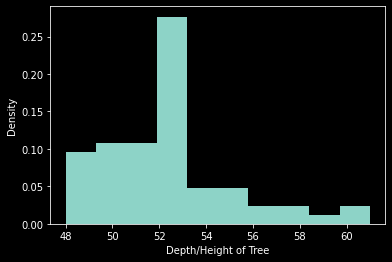

In [9]:
plt.hist([rf.estimators_[i].get_depth() for i in range(ntrees)],density=True)
plt.xlabel("Depth/Height of Tree")
plt.ylabel("Density")
plt.show()

The explained variance is: 0.7827225968501518
The R^2 is: 0.782684301918796
Mean Absolute Error is: 0.331689044146806
Mean Absolute Percentage Error is: 6.08815138801846


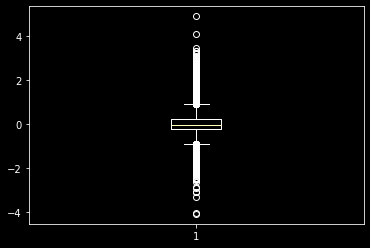

In [10]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = predictions-test_labels
print("The explained variance is: {}".format(skmetrics.explained_variance_score(test_labels, predictions)))
print("The R^2 is: {}".format(skmetrics.r2_score(test_labels, predictions)))
print('Mean Absolute Error is: {}'.format(skmetrics.mean_absolute_error(test_labels, predictions)))
print('Mean Absolute Percentage Error is: {}'.format(skmetrics.mean_absolute_percentage_error(test_labels, predictions)))
plt.boxplot(errors)
plt.show()

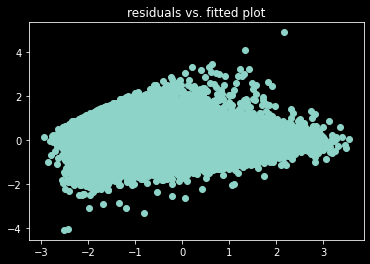

In [11]:
predictions = rf.predict(test_features)
plt.scatter(predictions, errors)
plt.title("residuals vs. fitted plot")
plt.show()

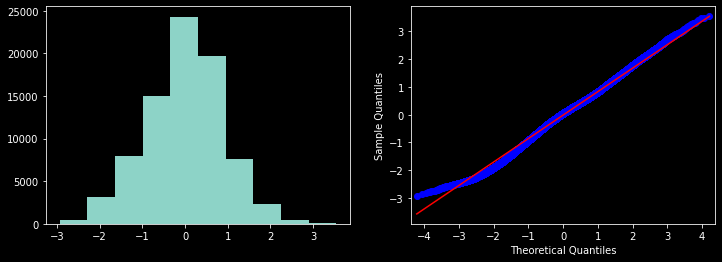

In [12]:
q_q_plot(predictions)

In [13]:
gdf = gpd.GeoDataFrame(ml_df, geometry=gpd.points_from_xy(ml_df.Longitude, ml_df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

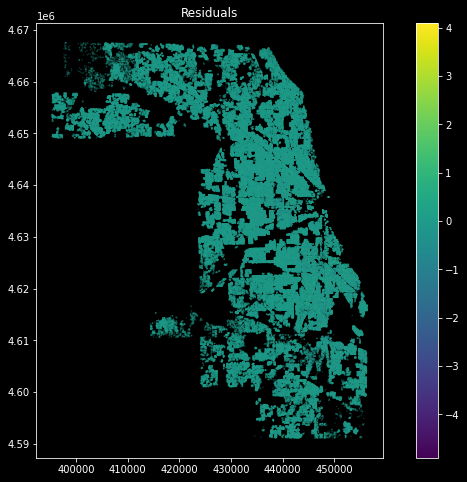

In [14]:
resid = labels.ravel() - rf.predict(features).ravel()
gdf.plot(column=resid, legend=True, alpha=0.5, figsize=(12,8), markersize=.1)
plt.title("Residuals")
plt.show()

In [ ]:
w = KNN.from_dataframe(gdf,k=256) # needed k large enough that it was connected

In [ ]:
w.transform = 'R'

In [ ]:
rfr_moran = Moran(resid, w, permutations=199)
plot_moran(rfr_moran, zstandard=True, figsize=(10,4))
plt.show()

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1][:20]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)):
    print("{:2d}. feature {:2d} = {:<30s} ({:1.4f})".format(f+1, indices[f], feature_list[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [ feature_list[i] for i in indices], rotation=45, ha="right")
plt.xlim([-1, len(indices)])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
# check if depth is too high
if np.mean([rf.estimators_[0].get_depth() for i in range(ntrees)]) < 8:
    tree = rf.estimators_[0]
    export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file('tree.dot')
    graph.write_png('tree.png')
else:
    print("Tree height is too large to realistically plot.")